In [2]:
import os
import re
import ast
import json
import re
from typing import Union
from langchain.schema import AIMessage  # Assuming you're using langchain

from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from dotenv import load_dotenv

In [3]:
load_dotenv()
## load the GROQ API Key
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

## If you do not have open AI key use the below Huggingface embedding
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [4]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# llm = ChatGroq(groq_api_key=groq_api_key, model_name="Llama3-8b-8192")
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")

/Users/amit/educative/grapRag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
llm.invoke("tell me a joke")

AIMessage(content='A man walked into a library and asked the librarian, "Do you have any books on Pavlov\'s dogs and Schrödinger\'s cat?" \n\nThe librarian replied, "It rings a bell, but I\'m not sure if it\'s here or not."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 39, 'total_tokens': 94, 'completion_time': 0.073333333, 'prompt_time': 0.002151647, 'queue_time': 0.003470714, 'total_time': 0.07548498}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_21a77a6a8c', 'finish_reason': 'stop', 'logprobs': None}, id='run-1cf281db-01b7-4c52-8c73-3ebecbadee1e-0', usage_metadata={'input_tokens': 39, 'output_tokens': 55, 'total_tokens': 94})

In [6]:
embeddings.embed_query("what is the embeddigng of this sentence?")

[0.057990118861198425,
 0.041364263743162155,
 0.06764058768749237,
 -0.017624542117118835,
 0.02342291921377182,
 0.05958905816078186,
 0.0754469484090805,
 0.023752905428409576,
 0.015532885678112507,
 -0.05032842233777046,
 0.10318584740161896,
 -0.007399195805191994,
 0.032279547303915024,
 -0.061198849231004715,
 -0.11143757402896881,
 0.0519709587097168,
 -0.0005154299433343112,
 0.02895287051796913,
 -0.10140156000852585,
 -0.014743875712156296,
 -0.056795231997966766,
 0.04892675206065178,
 0.05324842780828476,
 -0.04790183901786804,
 0.06571468710899353,
 0.08100837469100952,
 -0.01030375249683857,
 0.054838694632053375,
 0.0624050609767437,
 -0.030469104647636414,
 0.0011972725624218583,
 -0.061725467443466187,
 -9.515624697087333e-05,
 0.031651534140110016,
 -0.017107563093304634,
 0.037338435649871826,
 0.03405124321579933,
 -0.040304943919181824,
 0.035198111087083817,
 0.012985043227672577,
 0.018006347119808197,
 -0.022019468247890472,
 -0.013369687832891941,
 0.04718721

In [7]:
def extract_entities_relationships1(text):
    messages = [
        {
            "role": "system",
            "content": """"
  You are a helper tool for a knowedge graph builder application. Your task is to extract entities and relationships from the text provided by the user. 
  Format the output in such a way that it can be directly parsed into Python lists. 
  I do not want the innner working or code; I just need the output
  The format should include:
  
  1. A list of **Entities** in Python list format.
  2. A list of **Relationships**, where each relationship is represented as a tuple in the format: (Entity 1, "Relationship", Entity 2).
  
  Here is the format to follow:
  
  Entities: ["Entity 1", "Entity 2", ..., "Entity N"]
  
  Relationships: [("Entity 1", "Relationship", "Entity 2"), ..., ("Entity X", "Relationship", "Entity Y")]
  
  Example Input:
  Extract entities and relationships from the following text:
  "Michael Jackson, born in Gary, Indiana, was a famous singer known as the King of Pop. He passed away in Los Angeles in 2009."
  

  Expected Output:
  
  Entities: ["Michael Jackson", "Gary, Indiana", "Los Angeles", "singer", "King of Pop", "2009"]
  
  Relationships: [
    ("Michael Jackson", "born in", "Gary, Indiana"), 
    ("Michael Jackson", "profession", "singer"), 
    ("Michael Jackson", "referred to as", "King of Pop"), 
    ("Michael Jackson", "passed away in", "Los Angeles"), 
    ("Michael Jackson", "date of death", "2009")
  ]

  Please make sure that output confirms to the expected output format

  """,
        },
        {
            "role": "user",
            "content": f"Extract entities and relationship tuples from the following text:\n\n{text}\n\n",
        },
    ]

    response = llm.invoke(messages)
    return response


def parse_llm_response_content1(content: Union[str, AIMessage]):
    # If content is an AIMessage, extract the content string
    if isinstance(content, AIMessage):
        content = content.content
    print(content)
    # Extract entities
    entities_match = re.search(r"Entities: (\[.*?\])", content, re.DOTALL)
    entities = eval(entities_match.group(1)) if entities_match else []

    # Extract relationships
    relationships_match = re.search(r"Relationships: (\[.*?\])", content, re.DOTALL)
    relationships = eval(relationships_match.group(1)) if relationships_match else []

    # Count entities and relationships
    # nEntities = len(entities)
    # nRelationships = len(relationships)

    return entities, relationships

In [8]:
raw_text = "Sarah is an avid traveler who recently visited New York City. During her trip, she saw the Statue of Liberty, which was designed by Frédéric Auguste Bartholdi and completed in 1886. Sarah also visited the Empire State Building, which was completed in 1931 and was designed by Shreve, Lamb & Harmon. Sarah took a memorable photo in front of the Brooklyn Bridge, which was designed by John A. Roebling and completed in 1883. She also visited Central Park, a large public park in New York City."
content1 = extract_entities_relationships1(raw_text)
entities, relationships = parse_llm_response_content1(content1)
print("\n Entity list (Python):\n ", entities)
print("\n Relationship tuple list (Python):\n", relationships)

Entities: ["Sarah", "New York City", "Statue of Liberty", "Frédéric Auguste Bartholdi", "1886", "Empire State Building", "Shreve, Lamb & Harmon", "1931", "Brooklyn Bridge", "John A. Roebling", "1883", "Central Park"]

Relationships: [
  ("Sarah", "is an avid traveler who recently visited", "New York City"), 
  ("Sarah", "saw", "Statue of Liberty"), 
  ("Statue of Liberty", "was designed by", "Frédéric Auguste Bartholdi"), 
  ("Statue of Liberty", "was completed in", "1886"), 
  ("Sarah", "also visited", "Empire State Building"), 
  ("Empire State Building", "was completed in", "1931"), 
  ("Empire State Building", "was designed by", "Shreve, Lamb & Harmon"), 
  ("Sarah", "took a memorable photo in front of", "Brooklyn Bridge"), 
  ("Brooklyn Bridge", "was designed by", "John A. Roebling"), 
  ("Brooklyn Bridge", "was completed in", "1883"), 
  ("Sarah", "also visited", "Central Park"), 
  ("Central Park", "is a large public park in", "New York City")

 Entity list (Python):
  ['Sarah',

In [9]:
def extract_entities_relationships2(text):
    messages = [
        {
            "role": "system",
            "content": """"
  You are a helper tool for a knowedge graph builder application. Your task is to extract entities and relationships from the text provided by the user. 
  Format the output in such a way that it can be directly parsed into Python lists. 
  I do not want the innner working or code; I just need the output

  The format should include:
  
  1. A list of **Entities** in Python list format.
  2. A list of **Relationships**, where each relationship is represented as a tuple in the format: (Entity 1, "Relationship", Entity 2).
  
  Here is the format to follow:
  
  Entities: ["Entity 1", "Entity 2", ..., "Entity N"]
  
  Relationships: [("Entity 1", "Relationship", "Entity 2"), ..., ("Entity X", "Relationship", "Entity Y")]
  
  Example Input:
  Extract entities and relationships from the following text:
  "Michael Jackson, born in Gary, Indiana, was a famous singer known as the King of Pop. He passed away in Los Angeles in 2009."

  
  Expected Output:
  
  Entities: ["Michael Jackson", "Gary, Indiana", "Los Angeles", "singer", "King of Pop", "2009"]
  
  Relationships: [
      ("Michael Jackson", "born in", "Gary, Indiana"), 
      ("Michael Jackson", "profession", "singer"), 
      ("Michael Jackson", "referred to as", "King of Pop"), 
      ("Michael Jackson", "passed away in", "Los Angeles"), 
      ("Michael Jackson", "date of death", "2009")
  ]

  Please make sure that output confirms to the expected output format

  """,
        },
        {
            "role": "user",
            "content": f"Extract entities and relationship tuples from the following text:\n\n{text}\n\n",
        },
    ]

    response = llm.invoke(messages)
    return response


def parse_llm_response_content2(content: Union[str, AIMessage]):
    # If content is an AIMessage, extract the content string
    if isinstance(content, AIMessage):
        content = content.content
    print(content)
    # Split the output into entities and relationships sections
    entity_section = content.split("Entities:")[1].split("Relationships:")[0].strip()
    relationship_section = content.split("Relationships:")[1].strip()

    # Use ast.literal_eval to safely evaluate the string into Python lists
    entities = ast.literal_eval(entity_section)
    relationships = ast.literal_eval(relationship_section)

    return entities, relationships
    return entities, relationships

In [10]:
raw_text = "Sarah is an avid traveler who recently visited New York City. During her trip, she saw the Statue of Liberty, which was designed by Frédéric Auguste Bartholdi and completed in 1886. Sarah also visited the Empire State Building, which was completed in 1931 and was designed by Shreve, Lamb & Harmon. Sarah took a memorable photo in front of the Brooklyn Bridge, which was designed by John A. Roebling and completed in 1883. She also visited Central Park, a large public park in New York City."
content2 = extract_entities_relationships2(raw_text)
entities, relationships = parse_llm_response_content2(content2)
print("\n Entity list (Python):\n ", entities)
print("\n Relationship tuple list (Python):\n", relationships)

Entities: ["Sarah", "New York City", "Statue of Liberty", "Frédéric Auguste Bartholdi", "1886", "Empire State Building", "Shreve, Lamb & Harmon", "1931", "Brooklyn Bridge", "John A. Roebling", "1883", "Central Park", "John A. Roebling"]

Relationships: [
    ("Sarah", "is an avid traveler", ""),
    ("Sarah", "recently visited", "New York City"),
    ("Sarah", "saw", "Statue of Liberty"),
    ("Statue of Liberty", "was designed by", "Frédéric Auguste Bartholdi"),
    ("Statue of Liberty", "was completed in", "1886"),
    ("Sarah", "also visited", "Empire State Building"),
    ("Empire State Building", "was completed in", "1931"),
    ("Empire State Building", "was designed by", "Shreve, Lamb & Harmon"),
    ("Sarah", "took a memorable photo in front of", "Brooklyn Bridge"),
    ("Brooklyn Bridge", "was designed by", "John A. Roebling"),
    ("Brooklyn Bridge", "was completed in", "1883"),
    ("Sarah", "also visited", "Central Park"),
    ("Central Park", "is located in", "New York Cit

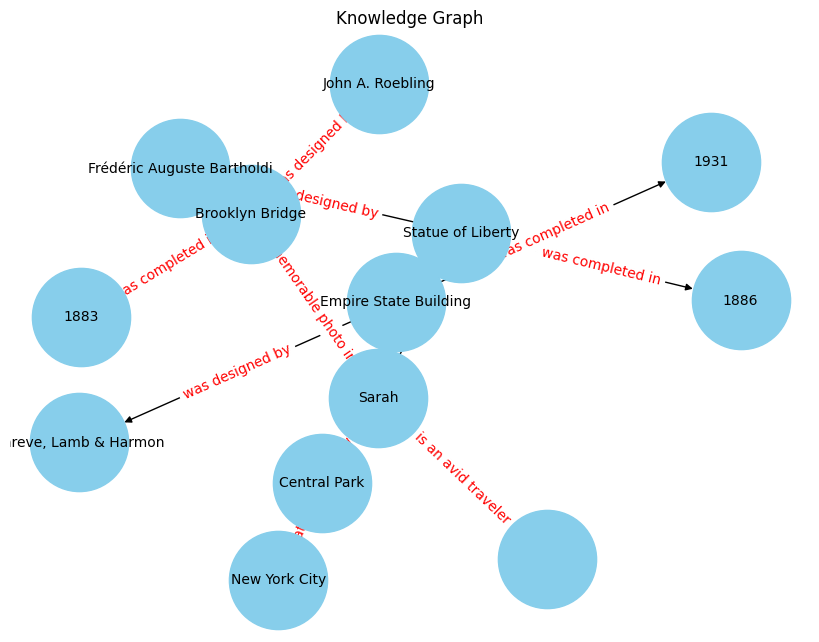

In [11]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_knowledge_graph(entities, relationships):
    G = nx.DiGraph()
    for entity1, relationship, entity2 in relationships:
        G.add_edge(entity1, entity2, label=relationship)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=5000,
        edge_color="black",
        font_size=10,
    )
    edge_labels = {
        (entity1, entity2): relationship
        for entity1, relationship, entity2 in relationships
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph")
    plt.show()


plot_knowledge_graph(entities, relationships)

In [12]:
from pydantic import BaseModel, Field
from typing import List, Tuple


class KnowledgeGraph(BaseModel):
    Entities: List[str] = Field(description="List of entities extracted from the text")
    Relationships: List[Tuple[str, str, str]] = Field(
        description="List of relationship tuples [Entity1, Relationship, Entity2]"
    )

In [24]:
system_prompt = """
You are a helper tool for a knowledge graph builder application. Your task is to extract entities and relationships from the text provided by the user, and output a valid JSON object with no additional text.
I do not want the innner working or code; I just need the output

The JSON should conform to this schema:
{
    "Entities": ["Entity 1", "Entity 2", ...],
    "Relationships": [
        ["Entity 1", "Relationship", "Entity 2"],
        ...
    ]
}

Example Input:
"Michael Jackson, born in Gary, Indiana, was a famous singer known as the King of Pop. He passed away in Los Angeles in 2009."

Expected Output:
{"Entities": ["Michael Jackson", "Gary, Indiana", "Los Angeles", "singer", "King of Pop", "2009"],
 "Relationships": [
     ["Michael Jackson", "born in", "Gary, Indiana"],
     ["Michael Jackson", "profession", "singer"],
     ["Michael Jackson", "referred to as", "King of Pop"],
     ["Michael Jackson", "passed away in", "Los Angeles"],
     ["Michael Jackson", "date of death", "2009"]
 ]}

"""

In [17]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
api_key = os.getenv("GROQ_API_KEY")

base_url = "https://api.groq.com/openai/v1"

In [26]:
import instructor
import openai

# Initialize the OpenAI client with Instructor
client = instructor.patch(
    openai.OpenAI(
        base_url="https://api.groq.com/openai/v1",
        api_key=os.environ.get("GROQ_API_KEY"),
    ),
    # mode=instructor.Mode.JSON,
)


def extract_knowledge_graph(text: str) -> KnowledgeGraph:
    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        response_model=KnowledgeGraph,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text},
        ],
    )
    return response

KnowledgeGraph(Entities=['Michael Jackson', 'Gary, Indiana', 'Los Angeles', 'singer', 'King of Pop', '2009'], Relationships=[('Michael Jackson', 'born in', 'Gary, Indiana'), ('Michael Jackson', 'profession', 'singer'), ('Michael Jackson', 'referred to as', 'King of Pop'), ('Michael Jackson', 'passed away in', 'Los Angeles'), ('Michael Jackson', 'date of death', '2009')])

In [27]:
# Example usage
raw_text_structured1 = "Michael Jackson, born in Gary, Indiana, was a famous singer known as the King of Pop. He passed away in Los Angeles in 2009."
result = extract_knowledge_graph(raw_text_structured1)
result

KnowledgeGraph(Entities=['Michael Jackson', 'Gary, Indiana', 'Los Angeles', 'singer', 'the King of Pop', '2009'], Relationships=[('Michael Jackson', 'born in', 'Gary, Indiana'), ('Michael Jackson', 'profession', 'singer'), ('Michael Jackson', 'refered to as', 'the King of Pop'), ('Michael Jackson', 'passed away in', 'Los Angeles'), ('Michael Jackson', 'date of death', '2009')])

In [ ]:
raw_text_structured2 = "Sarah is an avid traveler who recently visited New York City. During her trip, she saw the Statue of Liberty, which was designed by Frédéric Auguste Bartholdi and completed in 1886. Sarah also visited the Empire State Building, which was completed in 1931 and was designed by Shreve, Lamb & Harmon. Sarah took a memorable photo in front of the Brooklyn Bridge, which was designed by John A. Roebling and completed in 1883. She also visited Central Park, a large public park in New York City."
result = extract_knowledge_graph(raw_text_structured12
result